# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [62]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


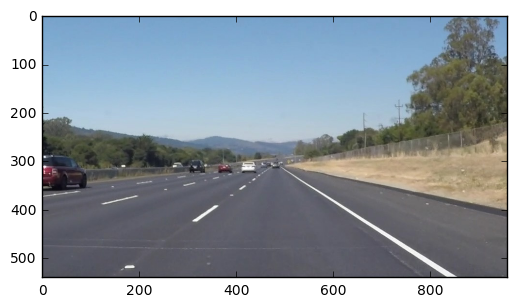

In [63]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [64]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

    #for one lane line the slope will be positive, for the other, it will be negative.
    #The "negative" slope will average the values of all negative slopes
    #The "positive" slope will average the values of all positives slopes. 
    #To make the lanes uninterrupting we will record the max-top and min-bottom values of the original slopes and
    
    negative_slope=0.0
    negative_slope_count=0
    
    positive_slope=0.0
    positive_slope_count=0
    
    min_y=img.shape[0]
    max_y=img.shape[0]-1  #this value will be constant. It will define the bottom of image where solid lanes are drawn
    
    positive_slope_x_list=[]
    positive_slope_y_list=[]
    
    negative_slope_x_list=[]
    negative_slope_y_list=[]

    for line in lines:
        for x1,y1,x2,y2 in line:
            
            slope=((y2-y1)/(x2-x1))
            #Here we do test the slope for an important assumption:
            # assumption is that the slope is within 25-70 degrees angle, 
            #(or alternatively 110-155 degrees for the opposite slope)
            #This way we can filter occasional horizonal lilnes that some time happend on the road 
            #(I found one at the end of solidYellowLeft.mp4 video)
            #to get the range the range for the slope corresponding to 25-70 degrees is (tan corresponding to range
            # 0.46-2.75), and the range for the slope corresponding to 110-155 degrees is (tan corresponding to range of 
            #-2.75 - -0.46)
            
            
            #if slope>=0:
            if slope>=0.46 and slope<=2.75:
                positive_slope_x_list.append(x1)
                positive_slope_x_list.append(x2)
                positive_slope_y_list.append(y1)
                positive_slope_y_list.append(y2)
            #else:
            elif slope>=-2.75 and slope<=-0.46:
                negative_slope_x_list.append(x1)
                negative_slope_x_list.append(x2)
                negative_slope_y_list.append(y1)
                negative_slope_y_list.append(y2)   
            else:
                continue
                
            if y1<min_y:
                min_y=y1
            if y2<min_y:
                min_y=y2

    
    positive_line=np.polyfit(positive_slope_x_list, positive_slope_y_list, 1)
    negative_line=np.polyfit(negative_slope_x_list, negative_slope_y_list, 1)

    
    #finding intersection of those lines with the horizonal lines from region of interest:
    #top(in the image) horizon line has the equation 0*x+Top_y, or parameters (0,Top_y) - slope =0
    #bottom(in the image) horizontal line has the equation 0*x+Bottom_y, or parameters (0,Bottom_y) slope=0
    top_horizontal_line=[0,min_y]
    bottom_horizontal_line=[0,max_y]
    
    positive_top_x=int((positive_line[1]-top_horizontal_line[1])*1.0/(top_horizontal_line[0]-positive_line[0]))
    positive_top_y=int(top_horizontal_line[1])
    #print ("Positive_top_x=",positive_top_x,"Positive_top_y=",positive_top_y)
    
    negative_top_x=int((negative_line[1]-top_horizontal_line[1])*1.0/(top_horizontal_line[0]-negative_line[0]))
    negative_top_y=int(top_horizontal_line[1])
    #print ("Negative_top_x=",negative_top_x,"Negative_top_y=",negative_top_y)
                
    positive_bottom_x=int((positive_line[1]-bottom_horizontal_line[1])*1.0/(bottom_horizontal_line[0]-positive_line[0]))
    positive_bottom_y=int(bottom_horizontal_line[1])
    #print ("Positive_bottom_x=",positive_bottom_x,"Positive_bottom_y=",positive_bottom_y)
    
    negative_bottom_x=int((negative_line[1]-bottom_horizontal_line[1])*1.0/(bottom_horizontal_line[0]-negative_line[0]))
    negative_bottom_y=int(bottom_horizontal_line[1])    
    #print ("Negative_bottom_x=",negative_bottom_x,"Negative_bottom_y=",negative_bottom_y)

    cv2.line(img, (positive_top_x, positive_top_y), (positive_bottom_x, positive_bottom_y), color, thickness)
    cv2.line(img, (negative_top_x, negative_top_y), (negative_bottom_x, negative_bottom_y), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,thickness=2):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines,thickness=thickness)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [66]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [65]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [67]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    #converting  the original image into grayscale
    image=image.astype('uint8')
    
    #checking if the image is in the range of (0,255)
    if(image.max()<1):
        image=image*256
    
    gray = grayscale(image)
    
    #blurring the grayscale image to remove spurious gradients
    gray_blurred=gaussian_blur(gray,5)
    
    #applying canny-edge detector to extract edges
    threshold_low=50
    threshold_high=150
    edge_image = canny(gray_blurred,threshold_low,threshold_high)
    
    #creating a mask for the region of interest (ROI)
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(430, 325), (530, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    ROI=region_of_interest(edge_image,vertices)
    
    #extractign hough lines from edges
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 90    # maximum gap in pixels between connectable line segments
    line_image = hough_lines(ROI, rho, theta, threshold, min_line_length, max_line_gap,thickness=10)
    result=weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    #result=ROI
    return result

Let's try the one with the solid white lane on the right first ...

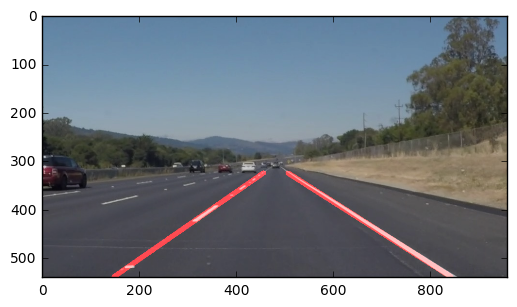

In [68]:
result=process_image(image)
plt.imshow(result)

In [69]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
#clip1 = VideoFileClip("solidYellowLeft.mp4")
#clip1 = VideoFileClip("challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4






  0%|          | 0/222 [00:00<?, ?it/s]



  3%|▎         | 6/222 [00:00<00:03, 58.71it/s]



  5%|▌         | 12/222 [00:00<00:03, 57.79it/s]



  8%|▊         | 18/222 [00:00<00:03, 57.96it/s]



 11%|█         | 24/222 [00:00<00:03, 56.90it/s]



 14%|█▍        | 31/222 [00:00<00:03, 58.40it/s]



 16%|█▌        | 36/222 [00:00<00:03, 51.68it/s]



 18%|█▊        | 41/222 [00:00<00:03, 48.63it/s]



 21%|██        | 46/222 [00:00<00:03, 46.14it/s]



 23%|██▎       | 51/222 [00:01<00:04, 41.62it/s]



 25%|██▌       | 56/222 [00:01<00:04, 39.10it/s]



 27%|██▋       | 60/222 [00:01<00:04, 35.45it/s]



 29%|██▉       | 64/222 [00:01<00:06, 24.04it/s]



 30%|███       | 67/222 [00:01<00:07, 21.56it/s]



 32%|███▏      | 70/222 [00:01<00:06, 23.01it/s]



 33%|███▎      | 73/222 [00:02<00:06, 21.70it/s]



 35%|███▍      | 77/222 [00:02<00:05, 24.65it/s]



 36%|███▌      | 80/222 [00:02<00:05, 26.01it/s]



 38%|███▊      | 84/222 [00:02<00:04, 27.97it/s]



 40%|███▉      | 8

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 50.3 s, sys: 492 ms, total: 50.8 s
Wall time: 8.94 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [70]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4






  0%|          | 0/682 [00:00<?, ?it/s]



  1%|          | 4/682 [00:00<00:21, 32.13it/s]



  1%|          | 8/682 [00:00<00:19, 34.04it/s]



  2%|▏         | 14/682 [00:00<00:17, 38.47it/s]



  3%|▎         | 19/682 [00:00<00:16, 40.22it/s]



  4%|▎         | 25/682 [00:00<00:14, 44.62it/s]



  5%|▍         | 31/682 [00:00<00:13, 48.20it/s]



  5%|▌         | 36/682 [00:00<00:14, 44.70it/s]



  6%|▌         | 41/682 [00:00<00:14, 44.24it/s]



  7%|▋         | 46/682 [00:01<00:14, 44.07it/s]



  7%|▋         | 51/682 [00:01<00:14, 44.36it/s]



  8%|▊         | 56/682 [00:01<00:14, 42.91it/s]



  9%|▉         | 61/682 [00:01<00:17, 36.46it/s]



 10%|▉         | 65/682 [00:01<00:21, 29.37it/s]



 10%|█         | 69/682 [00:01<00:22, 26.93it/s]



 11%|█         | 72/682 [00:01<00:24, 24.97it/s]



 11%|█         | 75/682 [00:02<00:24, 24.59it/s]



 11%|█▏        | 78/682 [00:02<00:25, 23.99it/s]



 12%|█▏        | 81/682 [00:02<00:27, 21.95it/s]



 12%|█▏        | 84

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 2min 56s, sys: 1.42 s, total: 2min 57s
Wall time: 29.9 s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In [71]:
#Project implements everything except the challenge and produces "white.mp4" and "yellow.mp4" as output.

# The project makes the following assumptions:
# a) There are two lines - left and right and both fall in the region of interest approximately corrsponding to a 
# triangle left-bottom-corner ---> center of the image --> right-bottom-corner
# b) Because of perspective projection effects the lane lines are pointing to a vanishing point on the horizon and,
# thus, are always in a certain range of degrees to the horizontal axis
# Using these assumptins it is possible to filter out spurious lines that do not belong to lanes

#The project does the following
#1) finds all edges in the region of interest: (0,539),(430, 325), (530, 325), (959,539)
#2) finds straight lines using Hough transform with min line size of 30 pixels and max gap of 90 pixels
#3) The found lines are put into two clusters - right line and left line. To qualify for the left line 
#   cluster a line needs to have a slope in the range of 25-70 degrees to horizontal axis (determined by its tan). For a line to be
#   considered to belong to the right cluster its slope needs to be in the range of 110-155 degrees (determined by its tan)
#   If a line does not make it to any of those angle ranges it is disregarded
#4) finding intersection of right and left left lines with the top and bottom  horizontal lines corresponding 
# to the region of interest, and, thus finds the end points for the left line and right lines
#5) displays the left and right lines in the image 

#both "White" and "yellow" videos look well annotated. I tried it with the "challenge" vide and I saw failure to 
# determine the lines in the middle of the video where the shadow of the tree breaks the appearance of the road 
# significantly so that the edge detector and subsequent hough transform does find any lines that would follow the 
# assumptions.
# it would be possible to make edge detector more adaptable (in terms of thresholds), but that would require a little
# more work. 
# Also, since the roads makes a curve it would be needed to shorten the annotation lines so that it only covers 
# the straight parts of the lane-markings

#Potential shortcomings of the current algorithm: The algorithms makes two strong assumptions (see above). So if any
# of the assumptiosn are broken the algorithm will break. For example if only a single lane-line is visible the 
# in the field of view (or in other words, in the region of interest), the algorihtm will still try to find the other
# line.., Also, the algorithm cannot display lines that are perpendicular to the vehicle since it is looking for lines
# within certain angle ranges (lines that would point to a vanishing point)

#Suggestions for improving the current algorithm:
# Overall, reliance on a edge detector is not a good idea as the appearance of edges varries a lot with the scenery. 
# Instead of the edge detector the real algortihm should detect the line-lanes as part of the road segmentation -
# where all the context of the road would make a stronger case for lanes. It is not an easy problem and the only strong
# solution for reliable road segmentation would involve deep learning based approaches. Alternatively, if lidar was 
# available, its output would be stronger since lane-lines are usually made of retro-reflective materials and produce
# high-intensity points

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [72]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4






  0%|          | 0/251 [00:00<?, ?it/s]



  1%|          | 3/251 [00:00<00:09, 25.41it/s]



  2%|▏         | 6/251 [00:00<00:09, 25.17it/s]



  4%|▎         | 9/251 [00:00<00:09, 25.11it/s]



  5%|▍         | 12/251 [00:00<00:09, 25.61it/s]



  6%|▌         | 15/251 [00:00<00:08, 26.24it/s]



  7%|▋         | 18/251 [00:00<00:08, 26.29it/s]



  8%|▊         | 21/251 [00:00<00:08, 25.80it/s]



 10%|▉         | 24/251 [00:00<00:08, 25.30it/s]



 11%|█         | 27/251 [00:01<00:08, 25.66it/s]



 12%|█▏        | 30/251 [00:01<00:08, 25.03it/s]



 13%|█▎        | 33/251 [00:01<00:08, 24.67it/s]



 14%|█▍        | 36/251 [00:01<00:08, 25.13it/s]



 16%|█▌        | 39/251 [00:01<00:08, 24.63it/s]



 17%|█▋        | 42/251 [00:01<00:08, 23.59it/s]



 18%|█▊        | 45/251 [00:01<00:09, 22.80it/s]



 19%|█▉        | 48/251 [00:02<00:09, 20.73it/s]



 20%|██        | 51/251 [00:02<00:10, 18.47it/s]



 21%|██        | 53/251 [00:02<00:11, 17.75it/s]



 22%|██▏       | 55/

TypeError: expected non-empty vector for x





 42%|████▏     | 106/251 [00:19<00:26,  5.54it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))